# DSCI100 Final Project Report

# Introduction
In this project, we will analyze data collected by a research group at UBC about how people play video games. Specifically, the research group has set up a Minecraft server to record players' actions and analyze how they navigate the world. However, to ensure they have enough resources to handle the number of players on their server. Our goal is to help with their recruitment efforts, we will be trying to answer which "kinds" of players are most likely to contribute a large amount of data to target those players in our recruiting efforts.

The dataset that we will be using to answer our question is the players.csv dataset which consists of a total of 196 observations and 9 different variables: 
1. **experience (chr):** Player's experience level 
2. **subscribe (lgl):** Indicates if a player is subscribed to PlaiCraft's email updates
3. **hashedEmail (chr):** Scrambled email of a player, which can be unscrambled with a key
4. **played_hours (dbl):** Total number of hours the player has played
5. **name (chr):** Player's name
6. **gender (chr):** Player's Gender
7. **age (dbl):** Player's Age
8. **individualID (lgl):** Individual ID of player
9. **organizationName (lgl):** Organization name of player

The second dataset is the sessions.csv dataset which consists of a total of 1536 observations and 5 different variables:
1. **hashedEmail (chr):** Scrambled email of a player, which can be unscrambled with a key
2. **start_time (chr):** Start time of player's session
3. **end_time (chr):** End time of player's session 
4. **original_start_time (dbl):** scheduled start time in seconds since 01/01/1970
5. **original_end_time (dbl):** scheduled end time in seconds since 01/01/1970

Although there are two datasets, we will strictly look at the players.csv dataset to answer which "kinds" of players are most likely to contribute a large amount of data. Specifically, we will be using both age and played_hours to predict the experience level of a player.

# Methods and Results

The method that we used to address our question using the players.csv dataset is KNN classification. This is appropriate because we are predicting a categorical variable (experience) using two numerical variables (age, played_hours). We will first plot the raw data to determine what wrangling is necessary.


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


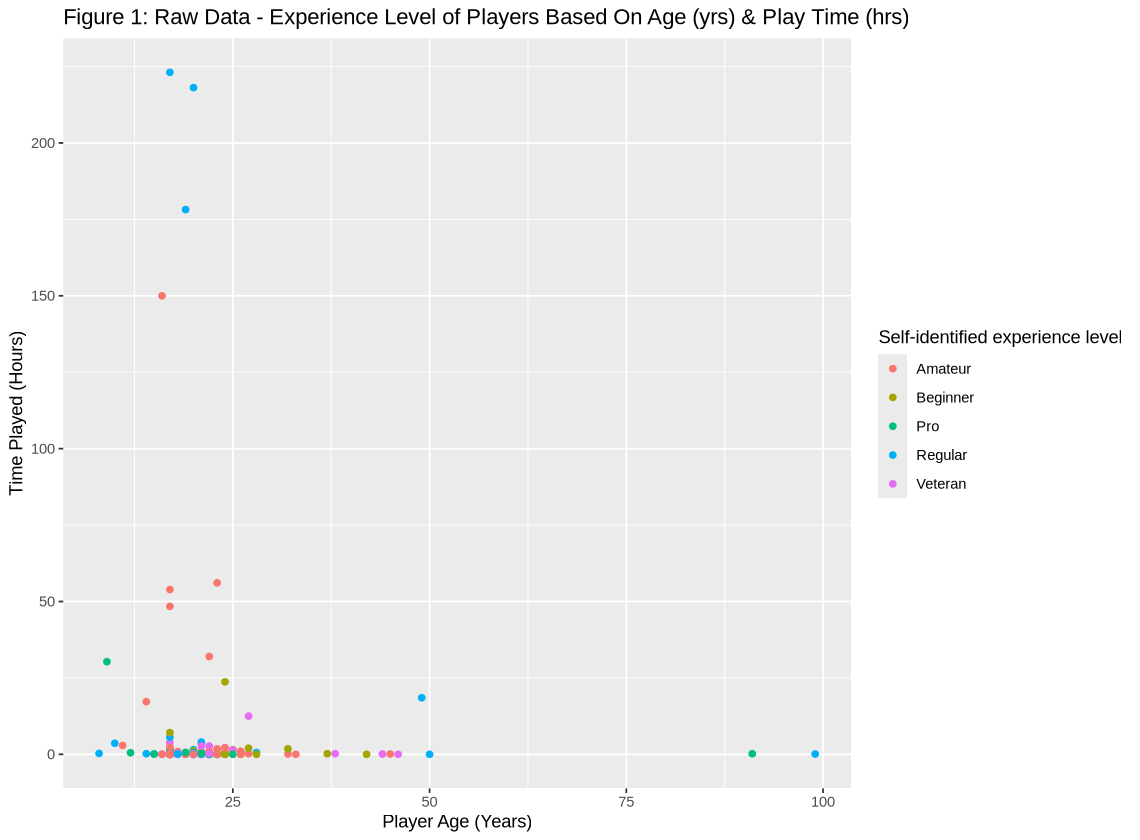

In [21]:
#initialising libraries
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
library(tidyclust)
library(ggplot2)
library(gridExtra)

#reading in the data
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players <- read_csv(players_url)

#initial plot of the three variables of interest: play time, age, & experience level
options(repr.plot.width = 9.5, repr.plot.height = 7) #initialising plot dimensions

raw_plot <- players |> ggplot(aes(x = age, y = played_hours)) + #plotting total hours played against player age
        geom_point(aes(color = experience)) + #labelling data points based on player experience
        labs(x = "Player Age (Years)",
                 y = "Time Played (Hours)", 
                 colour = "Self-identified experience level", 
                 title = "Figure 1: Raw Data - Experience Level of Players Based On Age (yrs) & Play Time (hrs)")
raw_plot

When we plot the raw data, we notice that there are far more observations for players under age 50 and those with 50 hours of play time or less. Namely, there are many players who contributed close to zero hours to the server, cluttering that part of the graph. Furthermore, if we are trying to analyze which players are most likely to contribute to a large amount of data, those with 0 played_hours would not be useful, as they are not contributing data at all. Assuming that the ideal demographic for the researchers would be those who are university to prime working age due to ease of sampling, we decided to filter the data to consider only those who are 50 years old or younger. Furthermore, since we are interested in players who would contribute a lot of play time to the server, we should only consider those who played more than 0 hours. Now, we may wrangle and clean our data to prepare it for analysis:

### Cleaning and Wrangling The Data

In [3]:
players_filtered <- players |>
    select(experience, played_hours, age) |> #select only relevant columns
    filter(played_hours != 0, age < 50) #filter the number of played hours and age

### Dataset Summary
The cleaned and wrangled dataset that we will be using for our analysis consists of total of 111 observations and 3 different variables:
1. **RESPONSE VARIABLE - experience (chr):** Player's experience level
4. **PREDICTOR VARIABLE - played_hours (dbl):** Total number of hours the player has played
7. **PREDICTOR VARIABLE - age (dbl):** Player's Age

Visualizing our cleaned data and labelling the datapoints based on player experience yields the following graph:

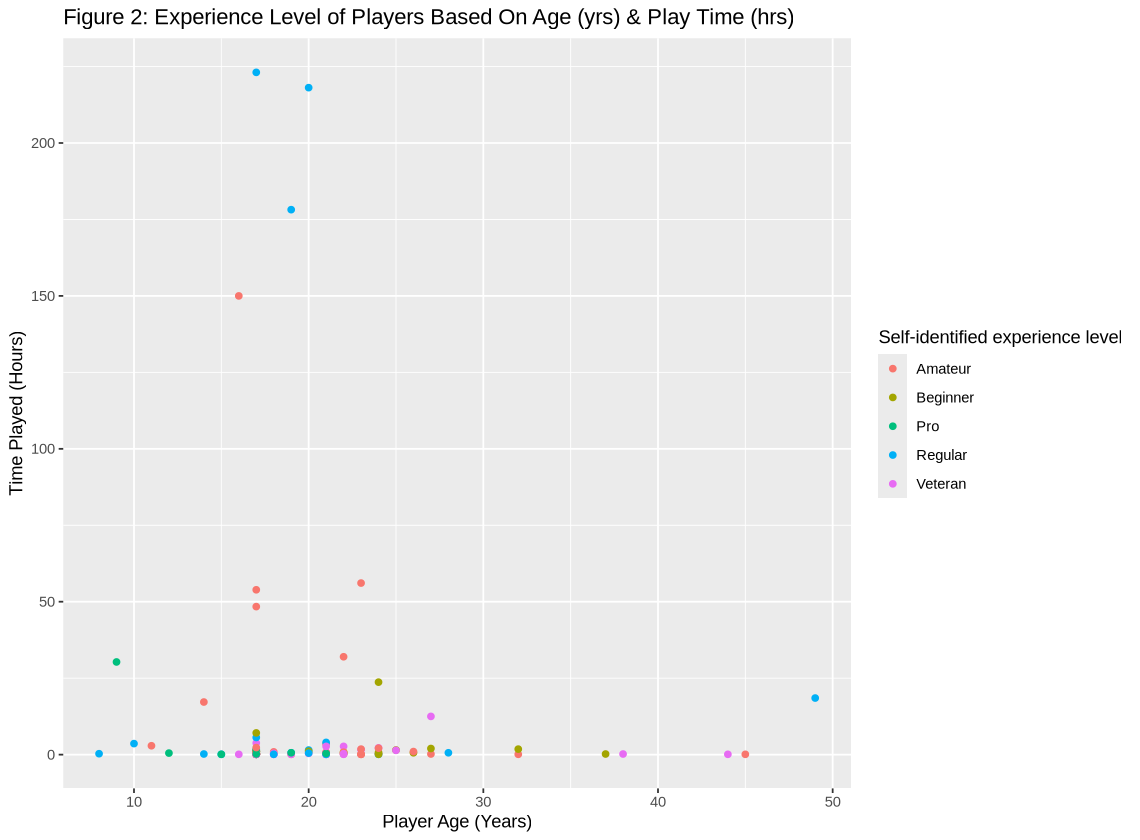

In [4]:
#plotting the cleaned data
players_plot <- players_filtered |>
            ggplot(aes(x = age, y = played_hours)) + #plotting total hours played against age of player
            geom_point(aes(color = experience)) + #labelling each point based on player experience
            labs(x = "Player Age (Years)",
                 y = "Time Played (Hours)", 
                 colour = "Self-identified experience level", 
                 title = "Figure 2: Experience Level of Players Based On Age (yrs) & Play Time (hrs)")
players_plot

Additionally, we create some visualizations to help with exploratory data analysis. This plot highlights the number of played hours for each experience level:

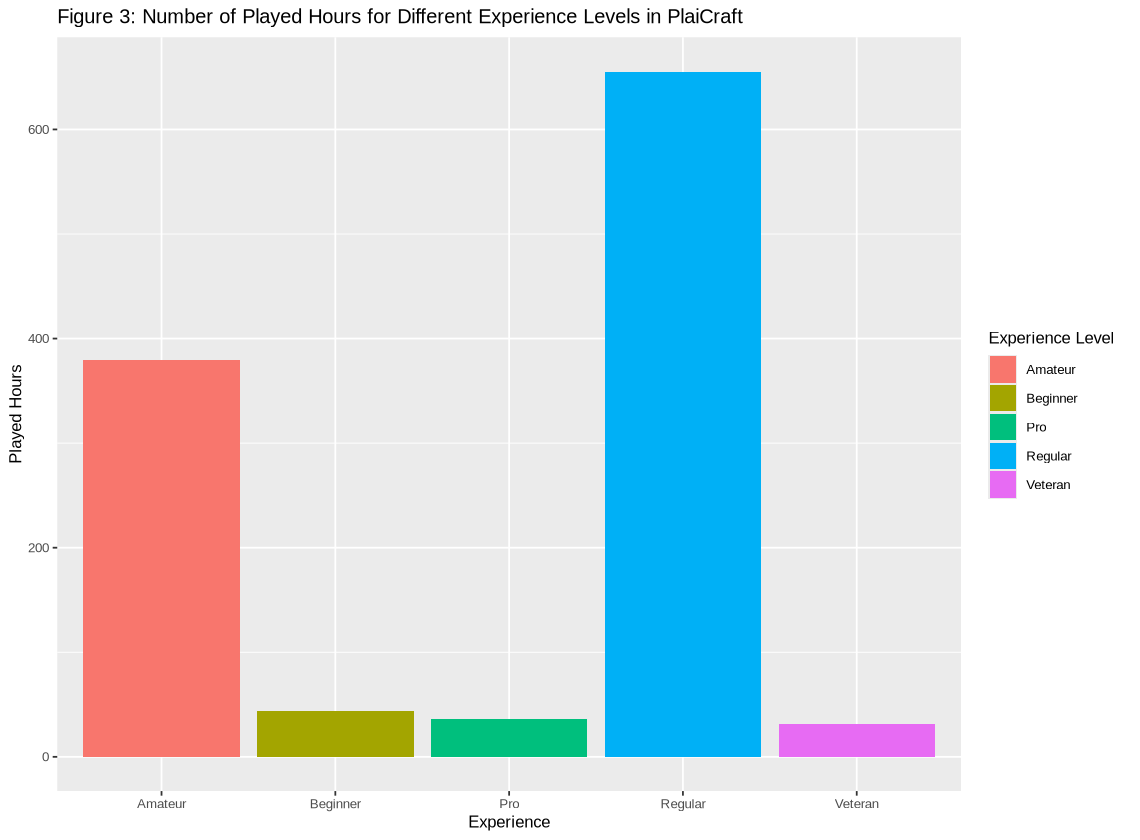

In [5]:
players_plot <- players_filtered |>
    ggplot(aes(x = experience, y = played_hours, fill = experience)) +
    geom_bar(stat = "identity") +
    labs(x = "Experience", y = "Played Hours", fill = "Experience Level") +
    ggtitle("Figure 3: Number of Played Hours for Different Experience Levels in PlaiCraft") +
        theme(text = element_text(size = 10))
players_plot

### KNN Classification Analysis

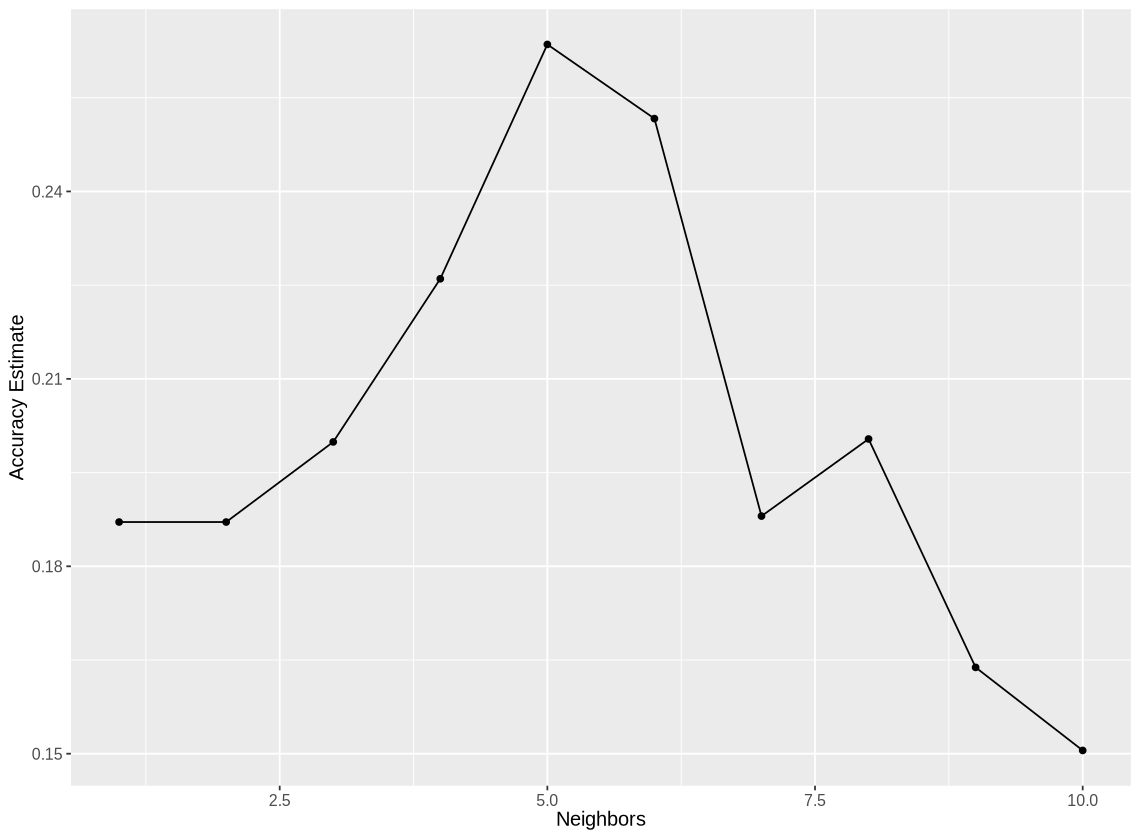

In [6]:
#splitting the data into training & testing data
set.seed(5555) #setting seed for reproducibility

players_filtered <- players_filtered |>
    mutate(experience = as_factor(experience)) |> #convert the character Class variable to the factor datatype
    drop_na(experience, age, played_hours)

split <- players_filtered |>
        initial_split(prop = 0.75, strata = experience) #randomly splitting the data into 75% training data & 25% testing data
training <- training(split) #training dataset, 80 observations
testing <- testing(split)  #testing dataset, 29 observations

experience_recipe <- recipe(experience ~ age + played_hours, data = players_filtered) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

experience_vfold <- vfold_cv(training, v = 3, strata = experience)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(experience_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = experience_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

After tuning the K-NN classifer and choosing K = 5, which is the neighbor with the highest accuracy score, we can now retrain our K-NN classifier on all of the training data, but this time using K = 5.

In [7]:
knn_spec_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_best_k <- workflow() |>
    add_recipe(experience_recipe) |>
    add_model(knn_spec_best_k) |>
    fit(data = training)

experience_test_predictions <- predict(knn_fit_best_k, testing) |>
    bind_cols(testing)

experience_test_predictions |>
    metrics(truth = experience, estimate = .pred_class) |>
    filter(.metric == "accuracy")

experience_test_predictions |>
    precision(truth = experience, estimate = .pred_class, event_level="first")

matrix <- experience_test_predictions |>
             conf_mat(truth = experience, estimate = .pred_class)
matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2068966


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.1366667


          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        0       1       1       1        0
  Veteran    0       0       0       1        0
  Amateur    0       5       4       3        3
  Regular    2       0       1       1        0
  Beginner   1       1       3       0        1

### Clustering Analysis

We begin by testing our model for clusters between 1 and 100. 

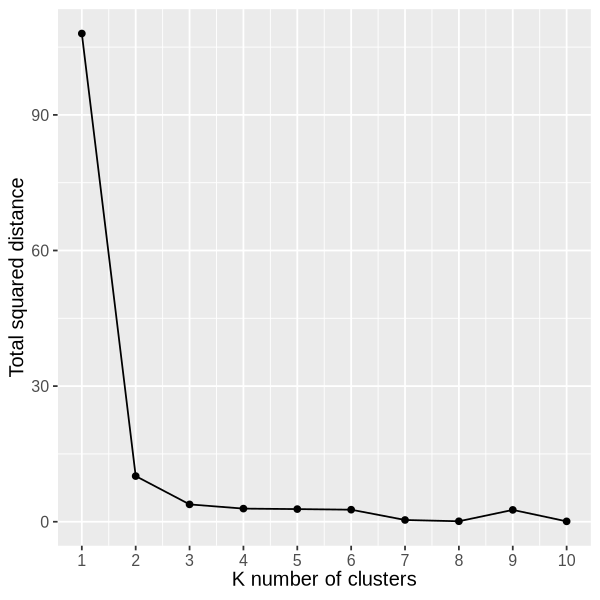

In [16]:
set.seed(5555) #setting seed for reproducibility

options(repr.plot.width = 5, repr.plot.height = 5)

players_kmeans <- k_means(num_clusters = tune()) |>
    set_engine("stats", nstart = 10)

players_recipe <- recipe(~ played_hours, age, data = players_filtered) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_ks <- tibble(num_clusters = 1 : 10)

players_elbow_stats <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_kmeans) |>
    tune_cluster(resamples = apparent(players_filtered), grid = players_ks) |>
    collect_metrics() |>
    mutate(total_WSSD = mean) |>
    filter(.metric == "sse_within_total") |>
    select(num_clusters, total_WSSD)

players_elbow_plot <- 
    ggplot(players_elbow_stats, 
               aes(x = num_clusters, y = total_WSSD)) +
        geom_point() +
        geom_line() +
        xlab("K number of clusters") +
        ylab("Total squared distance") +
        scale_x_continuous(breaks = 1:10) +
        theme(text = element_text(size = 12))
players_elbow_plot

We can identify from the plot above that that "elbow" occurs when K is 2, meaning that we can now retest the clusters for the correct K value.

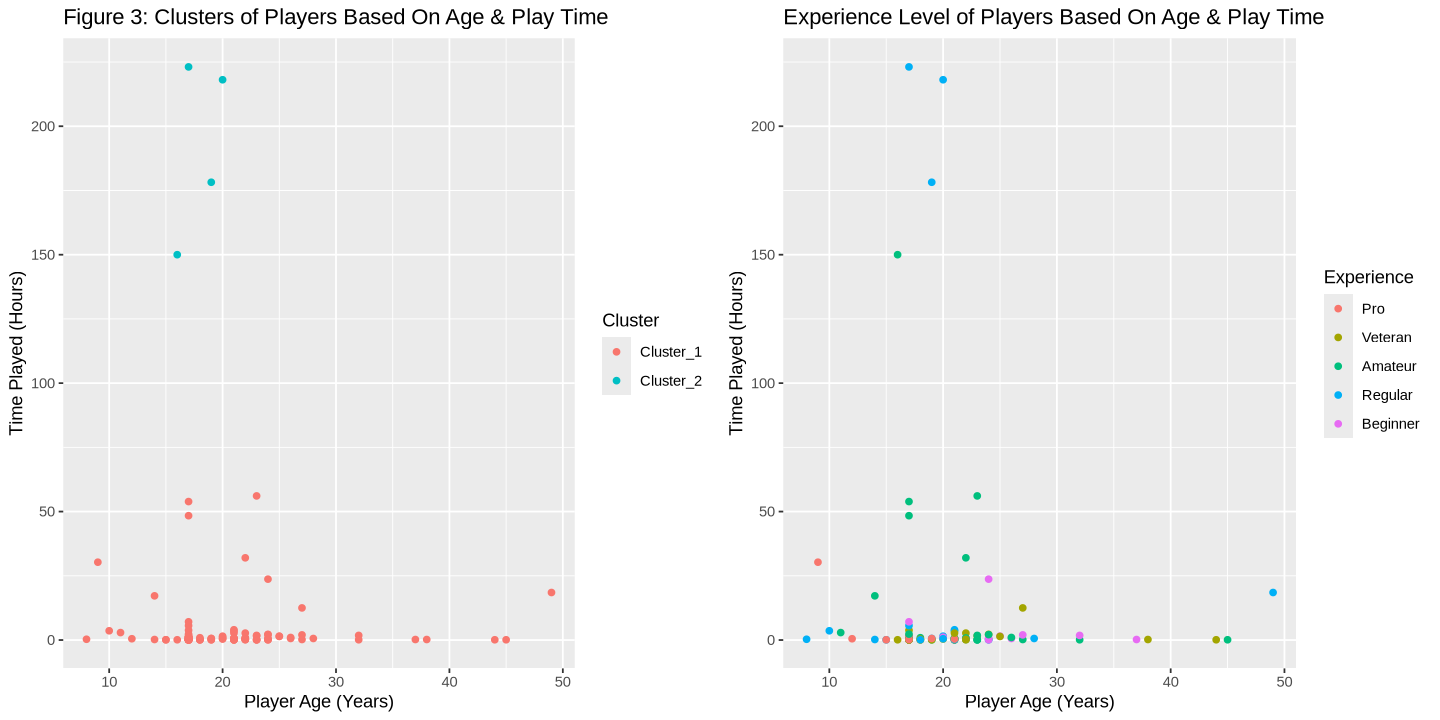

In [29]:
set.seed(2019) # DO NOT REMOVE
options(repr.plot.width = 12, repr.plot.height = 6)

players_final_kmeans <- k_means(num_clusters = 2) |>
    set_engine("stats", nstart = 10)

players_final_clusters <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_final_kmeans) |>
    fit(players_filtered) |>
    augment(players_filtered)

# Final cluster plot
players_final_clusters_plot <- 
    ggplot(players_final_clusters, 
           aes(x=age, y = played_hours, color = .pred_cluster)) +
        geom_point() +
        labs(x = "Player Age (Years)", y= "Time Played (Hours)", color = "Cluster") +
        ggtitle("Figure 3: Clusters of Players Based On Age & Play Time")

# Original filtered player plot
players_plot <- players_filtered |>
            ggplot(aes(x = age, y = played_hours)) + #plotting total hours played against age of player
            geom_point(aes(color = experience)) + #labelling each point based on player experience
            labs(x = "Player Age (Years)",
                 y = "Time Played (Hours)", 
                 colour = "Experience", 
                 title = "Experience Level of Players Based On Age & Play Time")

grid.arrange(players_final_clusters_plot, players_plot, ncol = 2)

# Discussion